Files already downloaded and verified


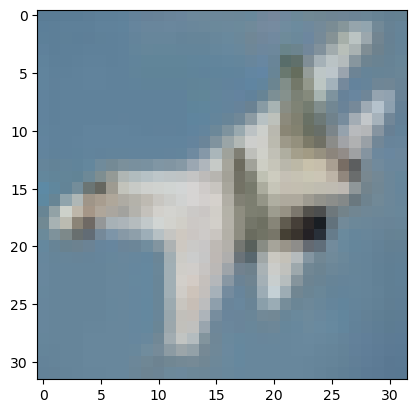

In [143]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

original_testset = torchvision.datasets.CIFAR10(root='Datasets',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

original_img = original_testset[10][0]

plt.imshow(original_img.permute(1,2,0))

save_image(original_img, 'Datasets/img.png')

In [144]:
import torch
import math

def aug_input(img):

    num_channel = img.shape[0]
    
    aug_tensors = torch.zeros(num_channel, aug_tensor_size)
    aug_img_shape = (int(math.sqrt(aug_tensor_size)), int(math.sqrt(aug_tensor_size)))
    aug_img = torch.zeros(num_channel, aug_img_shape[0], aug_img_shape[1])

    for c in range(num_channel):
        img_flat = torch.reshape(img[c], (-1,))
        j = 0
        for i in range(aug_tensor_size):
            if i in aug_indices[c]:
                aug_tensors[c][i] = np.random.normal(0, sigma_test / 255)
            else:
                aug_tensors[c][i] = img_flat[j]
                j += 1

        aug_img[c] = torch.reshape(aug_tensors[c], aug_img_shape)

    return aug_img

In [145]:
aug_percentage = 0.10

img = original_testset[10][0]
num_channel = img.shape[0]
img_dim = img.shape[2]
aug_persent = aug_percentage  # Set percentage
aug_dim = int(img_dim * aug_persent)
aug_tensor_dim = img_dim + aug_dim

aug_tensor_size = aug_tensor_dim * aug_tensor_dim
aug_size = aug_tensor_size - (img_dim * img_dim)
        
aug_indices = []
    
for i in range(num_channel):
    aug_indices.append(np.random.choice(np.arange(0, aug_tensor_size), replace=False, size=aug_size))

aug_indices = np.array(aug_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


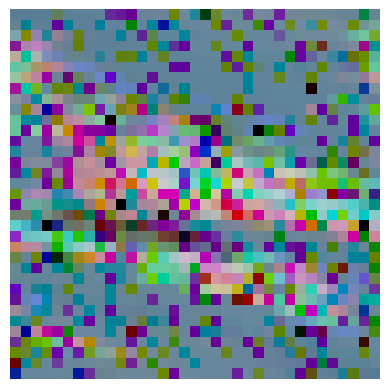

In [146]:
aug_img = aug_input(img)
plt.axis(False)
plt.imshow(aug_img.permute(1, 2, 0))
plt.show()

In [147]:
import cv2
import torch.nn.functional as F

sigma_test = 50
factor = 8

def load_img(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

file_ = 'Datasets/img.png'
gt = load_img(file_)

img = np.float32(gt) / 255.

np.random.seed(seed=0)  # for reproducibility
img += np.random.normal(0, sigma_test / 255., img.shape)
noisy = torch.from_numpy(img)

img = noisy.permute(2, 0, 1)
print(img.shape)

input_ = img.unsqueeze(0).cuda()

# Padding in case images are not multiples of 8
h, w = input_.shape[2], input_.shape[3]
H, W = ((h + factor) // factor) * factor, ((w + factor) // factor) * factor
padh = H - h if h % factor != 0 else 0
padw = W - w if w % factor != 0 else 0
input_ = F.pad(input_, (0, padw, 0, padh), 'reflect')

torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


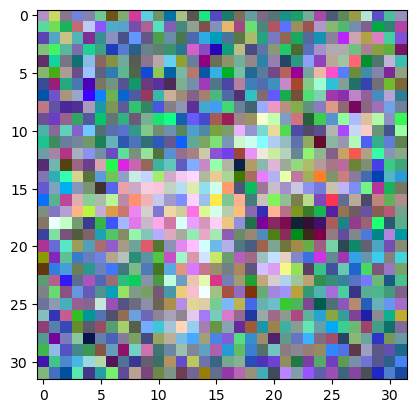

In [148]:
plt.imshow(input_.cpu()[0].permute(1, 2, 0))

In [153]:
import yaml
import torch.nn as nn
import os

from basicsr.models.archs.kbnet_s_arch import KBNet_s
from basicsr.models.archs.restormer_arch import Restormer

from basicsr.utils.util import patch_forward

try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader
    
yaml_file = 'Options/GaussianColorDenoising_RestormerSigma50.yml'
x = yaml.load(open(yaml_file, mode='r'), Loader=Loader)

s = x['network_g'].pop('type')
##########################

sigmas = [50]

factor = 8

datasets = ['CBSD68', 'Kodak', 'McMaster','Urban100']

for sigma_test in sigmas:
    print("Compute results for noise level",sigma_test)
    model_restoration = Restormer(**x['network_g'])
    weights = 'pretrained_models/gaussian_color_denoising_sigma50.pth'
    checkpoint = torch.load(weights)
    model_restoration.load_state_dict(checkpoint['params'])

    print("===>Testing using weights: ",weights)
    print("------------------------------------------------")
    model_restoration.cuda()
    model_restoration = nn.DataParallel(model_restoration)
    model_restoration.eval()

# factor = 8

# yaml_file = 'Options/GaussianColorDenoising_RestormerSigma50.yml'
# x = yaml.load(open(yaml_file, mode='r'), Loader=Loader)

# sigmas = [x['datasets']['train']['sigma_range']]
# cfg_name = os.path.basename(yaml_file).split('.')[0]
# pth_path = x['path']['pretrain_network_g']
# print('**', yaml_file, pth_path)

# s = x['network_g'].pop('type')
# model_restoration = eval(s)(**x['network_g'])
# checkpoint = torch.load(pth_path)

# print("===>Testing using weights: ")
# model_restoration.cuda()
# model_restoration = nn.DataParallel(model_restoration)
# model_restoration.load_state_dict(checkpoint['net'])
# model_restoration.eval()

# # restored = patch_forward(input_, model_restoration)
# restored = model_restoration(input_)

# # Unpad images to original dimensions
# restored = restored[:, :, :h, :w]

# plt.imshow(restored.detach().cpu()[0].permute(1, 2, 0))

Compute results for noise level 50
===>Testing using weights:  pretrained_models/gaussian_color_denoising_sigma50.pth
------------------------------------------------


In [ ]:
img = aug_img
print(img.shape)

input_ = img.unsqueeze(0).cuda()

# Padding in case images are not multiples of 8
h, w = input_.shape[2], input_.shape[3]
H, W = ((h + factor) // factor) * factor, ((w + factor) // factor) * factor
padh = H - h if h % factor != 0 else 0
padw = W - w if w % factor != 0 else 0
input_ = F.pad(input_, (0, padw, 0, padh), 'reflect')



In [ ]:
from numpy import random

x = np.random.normal(0, sigma_test / 255)

print(x)